<a id='sec0'></a>
# Predictive annotation of quantification methods 4
Idea is to use the descriptive text for each dataset to predict which quantification method was used for the experiments for the dataset. Below is an outline for the process.<br>
- <a href='#sec4'><b>Classification for tmt</b></a>

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import gensim
from gensim import corpora, models
from gensim import matutils
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
        accuracy_score, precision_score, recall_score,
        average_precision_score, f1_score,
        brier_score_loss, classification_report,
        precision_recall_curve, roc_auc_score, roc_curve)

#### Loading data

In [3]:
if True:
    with open('serialized_data/processed_df_plus_dummies.pickle', 'rb') as out_df:
        df =pickle.load(out_df)
    
    sample_tfidf = corpora.MmCorpus('nlp13_data/sample_tfidf.mm')
    data_tfidf = corpora.MmCorpus('nlp13_data/data_tfidf.mm')
    protocols_tfidf = corpora.MmCorpus('nlp13_data/protocols_tfidf.mm')
    description_tfidf = corpora.MmCorpus('nlp13_data/description_tfidf.mm')
    whole_tfidf = corpora.MmCorpus('nlp13_data/whole_tfidf.mm')
    my_dictionary = corpora.Dictionary.load('nlp13_data/whole_dictionary.dict')
    print(my_dictionary)

Dictionary(22736 unique tokens: ['-pron-', 'activation', 'aggressive', 'alkylation', 'also']...)


In [4]:
df.head(2)

,dataset_id,sample_protocol,data_protocol,description,quant_methods,silac,ms1_label_free,spectrum_counting,tmt,itraq,label_free
0,PXD000029,"[breast, cancer, tissue, lysate, reduction, al...","[proteomic, datum, analysis, proteome, discove...","[current, prognostic, factor, insufficient, pr...",itraq,0,0,0,0,1,0
1,PXD000164,"[protein, extraction, catheter, biofilm, small...","[mass, spectrometric, analyse, the, tryptic, d...","[long, term, catheterization, lead, inevitably...",label free,0,0,0,0,0,1


#### Functions for classification tasks

In [5]:
def classifyCV(clf, corpus, target, name=None, n_splits=5, num_terms=22736):
    # Set features and y
    if type(corpus) == np.ndarray:    # This is just for convenience later. Not a good coding design though.
        X = corpus
    else:
        X = matutils.corpus2dense(corpus, num_terms=num_terms).T
    y = np.array(target)
    
    # Cross Validation Loop
    kf = KFold(n_splits=n_splits)
    results = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        
        # create result dictionary
        result = {}
        result['classifier'] = name

        # Fit a model and predict
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)
        
        # Get metrics
        result['CV_fold'] = n_splits
        result['accuracy'] = accuracy_score(y_test, y_pred)
        result['precision'] = precision_score(y_test, y_pred)
        result['recall'] = recall_score(y_test, y_pred)
        result['average_precision'] = average_precision_score(y_test, y_proba[:, 1])
        result['Brier_loss'] = brier_score_loss(y_test, y_proba[:, 1])
        result['f1'] = f1_score(y_test, y_pred)

        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        result['fpr'] = fpr
        result['tpr'] = tpr
        result['roc_auc'] = roc_auc_score(y_test, y_proba[:, 1])
        
        precision_, recall_, _ = precision_recall_curve(y_test, y_proba[:, 1])
        result['precision_vals'] = precision_
        result['recall_vals'] = recall_

        results.append(result)
            
    results = pd.DataFrame(results)
    
    return results

def get_stats(results, label):
    col = results[label]
    mean = col.mean()
    std = col.std()
    print('%s: %.2f +/- %.3f' % (label, mean, std))
    return

def summarize_results(results, clf_label='', target_label='', plot_result=True):
    score_cols = [
        'accuracy',
        'precision',
        'recall',
        'f1',
        'average_precision',
        'roc_auc',
        'Brier_loss',
    ]
    print('='*10, '%s %d-fold CV stats' % (clf_label, len(results)), '='*10)
    for col in score_cols:
        get_stats(results, col)
    
    if plot_result:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        t = np.linspace(0, 1, 10)
        ax1.plot(t, t, ls='--', lw=0.5, color='0.3')
        for i in range(len(results)):
            fpr = results.fpr.iloc[i]
            tpr = results.tpr.iloc[i]
            ax1.plot(fpr, tpr, label=('CV %d' % (i+1)))
            ax1.set_xlabel('False Positive Rate')
            ax1.set_ylabel('True Positive Rate')
            ax1.set_title('ROC: Logistic Regr. (\'%s\')' % target_label)
            ax1.legend()

            precision_vals = results.precision_vals.iloc[i]
            recall_vals = results.recall_vals.iloc[i]
            ax2.plot(recall_vals, precision_vals, label=('CV %d' % (i+1)))
            ax2.set_xlabel('Recall')
            ax2.set_ylabel('Precision')
            ax2.set_title('Precision-Recall: Logistic Regr. (\'%s\')' % target_label)
            ax2.legend()

        fig.tight_layout()
    return

<a id='sec4'></a>
## tmt

#### Feature Selection

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklea

========== RFC 5-fold CV stats ==========
accuracy: 0.88 +/- 0.044
precision: 0.00 +/- 0.000
recall: 0.00 +/- 0.000
f1: 0.00 +/- 0.000
average_precision: 0.81 +/- 0.062
roc_auc: 0.94 +/- 0.028
Brier_loss: 0.09 +/- 0.029


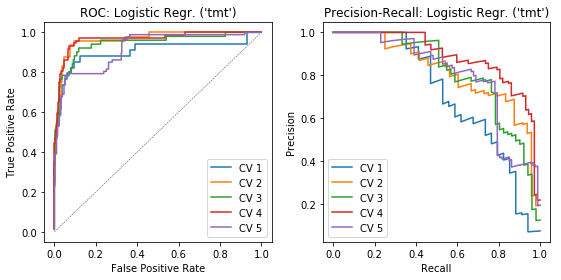

In [6]:
rfc = RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=8)
initial_results = classifyCV(rfc, protocols_tfidf, df.tmt,
    name='RFC', n_splits=5, num_terms=22736)
summarize_results(initial_results, clf_label='RFC', target_label='tmt')

In [7]:
# Get number of non-zero features
rfc.n_features_, np.count_nonzero(rfc.feature_importances_)

(22736, 808)

In [27]:
pd.Series(rfc.feature_importances_).describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    22736.000000
mean         0.000044
std          0.000484
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          0.000000
95%          0.000000
99%          0.001253
max          0.029594
dtype: float64

In [28]:
X0 = matutils.corpus2dense(protocols_tfidf, num_terms=22736).T

new_inds1 = np.argwhere(rfc.feature_importances_ >= 0.001).flatten()
new_inds2 = np.argwhere(rfc.feature_importances_ >= 0.005).flatten()
new_inds3 = np.argwhere(rfc.feature_importances_ >= 0.01).flatten()
new_inds4 = np.argwhere(rfc.feature_importances_ >= 0.015).flatten()

X1 = X0[:, new_inds1]
X2 = X0[:, new_inds2]
X3 = X0[:, new_inds3]
X4 = X0[:, new_inds4]

print('Shape before:', X0.shape)
print('Shape X1   :', X1.shape)
print('Shape X2   :', X2.shape)
print('Shape X3   :', X3.shape)
print('Shape X3   :', X4.shape)

Shape before: (2387, 22736)
Shape X1   : (2387, 286)
Shape X2   : (2387, 24)
Shape X3   : (2387, 10)
Shape X3   : (2387, 5)


In [29]:
# Check fraction of spectrum_counting class
print('Fraction with spectrum_counting = %.2f%%' % (100*df.tmt.sum()/len(df)))

Fraction with spectrum_counting = 12.23%


##### With RFC

In [30]:
rfcX1 = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
rfcX2 = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
rfcX3 = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
rfcX4 = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)

res_X1 = classifyCV(rfcX1, X1, df.tmt, name='RFC', n_splits=10, num_terms=22736)
res_X2 = classifyCV(rfcX2, X2, df.tmt, name='RFC', n_splits=10, num_terms=22736)
res_X3 = classifyCV(rfcX3, X2, df.tmt, name='RFC', n_splits=10, num_terms=22736)
res_X4 = classifyCV(rfcX4, X4, df.tmt, name='RFC', n_splits=10, num_terms=22736)

========== RFC with X1 10-fold CV stats ==========
accuracy: 0.97 +/- 0.020
precision: 0.99 +/- 0.036
recall: 0.77 +/- 0.101
f1: 0.86 +/- 0.069
average_precision: 0.94 +/- 0.042
roc_auc: 0.98 +/- 0.020
Brier_loss: 0.03 +/- 0.009
========== RFC with X2 10-fold CV stats ==========
accuracy: 0.99 +/- 0.009
precision: 0.98 +/- 0.029
recall: 0.90 +/- 0.066
f1: 0.94 +/- 0.040
average_precision: 0.95 +/- 0.036
roc_auc: 0.98 +/- 0.023
Brier_loss: 0.02 +/- 0.006
========== RFC with X3 10-fold CV stats ==========
accuracy: 0.99 +/- 0.009
precision: 0.98 +/- 0.030
recall: 0.89 +/- 0.073
f1: 0.93 +/- 0.044
average_precision: 0.95 +/- 0.037
roc_auc: 0.98 +/- 0.018
Brier_loss: 0.02 +/- 0.006
========== RFC with X4 10-fold CV stats ==========
accuracy: 0.98 +/- 0.010
precision: 0.94 +/- 0.044
recall: 0.89 +/- 0.075
f1: 0.91 +/- 0.049
average_precision: 0.91 +/- 0.053
roc_auc: 0.95 +/- 0.033
Brier_loss: 0.02 +/- 0.008


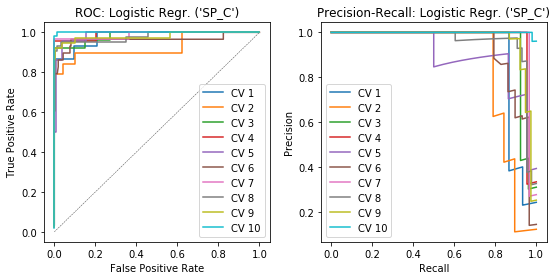

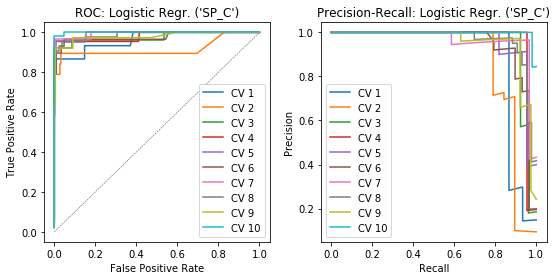

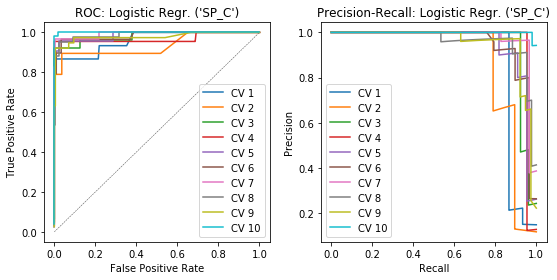

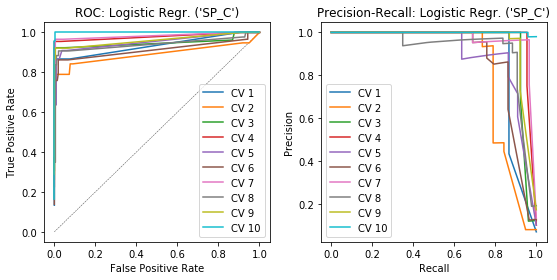

In [31]:
summarize_results(res_X1, clf_label='RFC with X1', target_label='SP_C', plot_result=True)
summarize_results(res_X2, clf_label='RFC with X2', target_label='SP_C', plot_result=True)
summarize_results(res_X3, clf_label='RFC with X3', target_label='SP_C', plot_result=True)
summarize_results(res_X4, clf_label='RFC with X4', target_label='SP_C', plot_result=True)

#### With LR

In [32]:
lrX1 = LogisticRegression(penalty='l1', C=10)
lrX2 = LogisticRegression(penalty='l1', C=10)
lrX3 = LogisticRegression(penalty='l1', C=10)
lrX4 = LogisticRegression(penalty='l1', C=10)

res_X1lr = classifyCV(lrX1, X1, df.tmt, name='LR', n_splits=10, num_terms=22736)
res_X2lr = classifyCV(lrX2, X2, df.tmt, name='LR', n_splits=10, num_terms=22736)
res_X3lr = classifyCV(lrX3, X3, df.tmt, name='LR', n_splits=10, num_terms=22736)
res_X4lr = classifyCV(lrX4, X4, df.tmt, name='LR', n_splits=10, num_terms=22736)

========== LR with X1 10-fold CV stats ==========
accuracy: 0.98 +/- 0.014
precision: 0.95 +/- 0.042
recall: 0.85 +/- 0.085
f1: 0.89 +/- 0.049
average_precision: 0.94 +/- 0.035
roc_auc: 0.97 +/- 0.019
Brier_loss: 0.02 +/- 0.011
========== LR with X2 10-fold CV stats ==========
accuracy: 0.98 +/- 0.013
precision: 0.96 +/- 0.052
recall: 0.83 +/- 0.080
f1: 0.89 +/- 0.048
average_precision: 0.94 +/- 0.037
roc_auc: 0.96 +/- 0.025
Brier_loss: 0.02 +/- 0.011
========== LR with X3 10-fold CV stats ==========
accuracy: 0.98 +/- 0.013
precision: 0.97 +/- 0.036
recall: 0.82 +/- 0.079
f1: 0.88 +/- 0.049
average_precision: 0.93 +/- 0.046
roc_auc: 0.96 +/- 0.029
Brier_loss: 0.02 +/- 0.012
========== LR with X4 10-fold CV stats ==========
accuracy: 0.98 +/- 0.015
precision: 0.97 +/- 0.038
recall: 0.83 +/- 0.091
f1: 0.89 +/- 0.058
average_precision: 0.91 +/- 0.057
roc_auc: 0.95 +/- 0.030
Brier_loss: 0.02 +/- 0.012


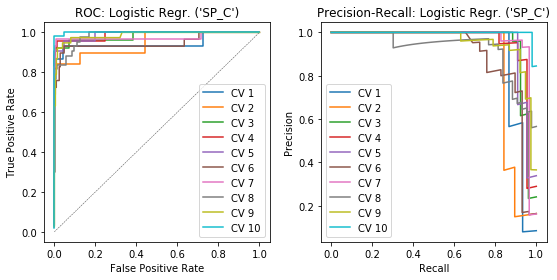

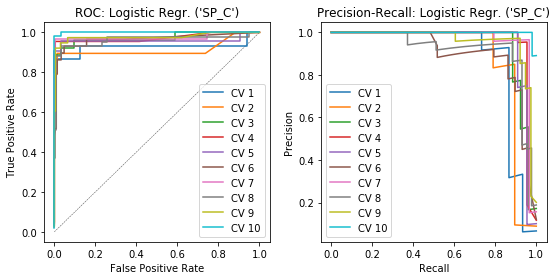

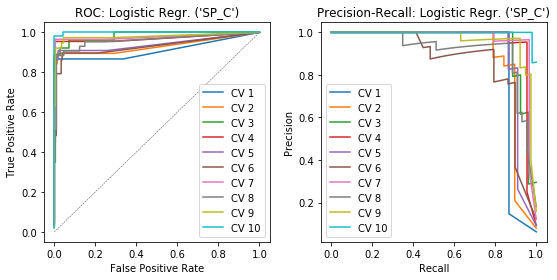

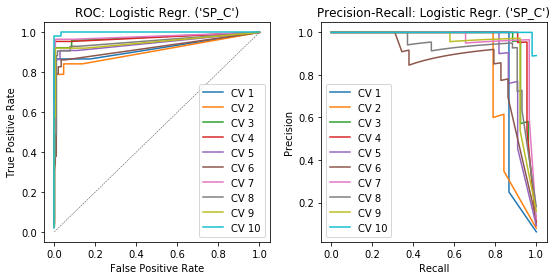

In [33]:
summarize_results(res_X1lr, clf_label='LR with X1', target_label='SP_C', plot_result=True)
summarize_results(res_X2lr, clf_label='LR with X2', target_label='SP_C', plot_result=True)
summarize_results(res_X3lr, clf_label='LR with X3', target_label='SP_C', plot_result=True)
summarize_results(res_X4lr, clf_label='LR with X4', target_label='SP_C', plot_result=True)

In [34]:
reverse_dict = {v:k for k, v in my_dictionary.token2id.items()}

In [35]:
inds_collection = [new_inds2, new_inds3, new_inds4]
for i, ind_set in enumerate(inds_collection):
    print('='*10, 'Feature Set %d' % (i+2),'='*10)
    for ind in ind_set:
        print(reverse_dict[ind])

========== Feature Set 2 ==========
labeling
integration
pool
sequest
thermo
instruction
label
manufacturer
tag
tmt
tagging
channel
δcn
reagent
termini
xbridge
notch
reporter
anhydrous
hydroxylamine
quantifier
teabc
tribrid
synchronous
========== Feature Set 3 ==========
pool
tag
tmt
reagent
termini
notch
reporter
anhydrous
hydroxylamine
synchronous
========== Feature Set 4 ==========
tmt
reagent
termini
reporter
hydroxylamine
